In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import glob
import os
import matplotlib.pyplot as plt
import math

#Umap
import matplotlib.pyplot as plt
from umap import UMAP
import umap

from pointgrid import align_points_to_grid

# t-SNE
from sklearn.manifold import TSNE
from sklearn.manifold import trustworthiness

#Wordclouds
from wordcloud import WordCloud
from PIL import Image, ImageDraw

from os import path
import multidict as multidict

from scipy.spatial import ConvexHull
from scipy import interpolate

# Data

In [12]:
# Import

path_in = 'data/csv/freihand_signatures.csv'

df = pd.read_csv(path_in)

# Export 

columns_export =['id', 'lang', 'title', 'year', 'embedding_x', 'embedding_y', 'cluster', 'subject_list']

path_out = '../BHVizApp/src/data/mapping_out_sample.csv'

In [13]:
df = df.sample(10000)

## Word Tokenization

In [14]:
text_cols = ['text', 'text_3', 'text_2', 'text_1']
df['subject_list'] = df[text_cols].apply(lambda x: ' '.join(x.astype(str)), axis=1)

# vectorizer = CountVectorizer(min_df=5)
# subject_doc_matrix = vectorizer.fit_transform(df.subject_list)

tfidf = TfidfVectorizer()
subject_doc_matrix = tfidf.fit_transform(df.subject_list)

# Dimensionality Reduction

### UMAP

In [ ]:
# reducer = UMAP(random_state=42, n_components = 2, metric='cosine')

# Using hellinger metric the points without neighbors are mapped to nan.
reducer = UMAP(random_state=42, n_components = 2, min_dist=0.01, n_neighbors=3, metric='hellinger') 
umap_emb = reducer.fit_transform(subject_doc_matrix)


c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\umap\spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\umap\spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


Text(0.5, 1.0, 'Metric: cosine, Number of neighbors: 10, Minimum Distance: 0.25,\nUMAP trustworthiness: 0.974')

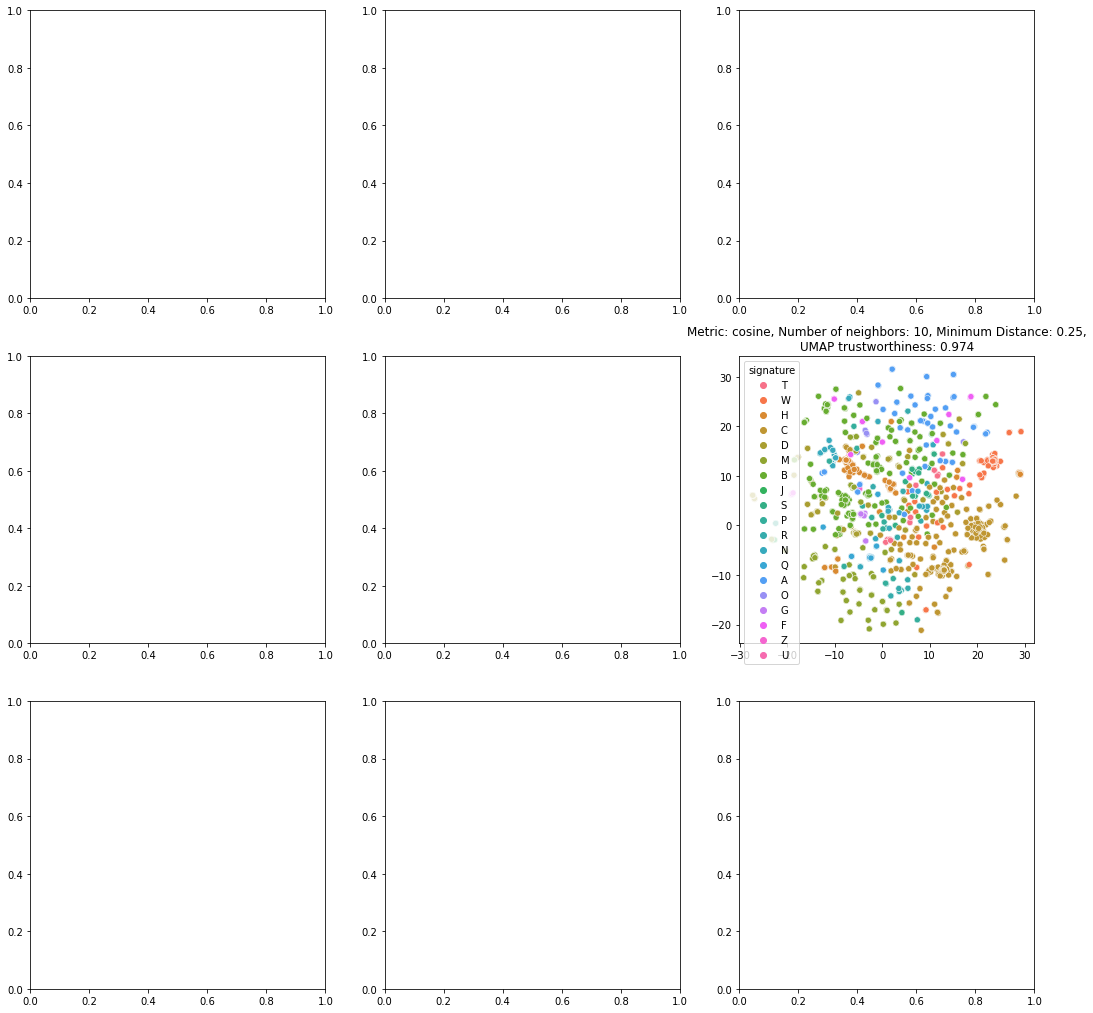

In [10]:
metrics = ['cosine', 'euclidean']
neighbors = [10, 50, 100]
min_dist = [0.1, 0.25, 0.75]

# Create a subplot grid for the scatterplots
fig, axs = plt.subplots(len(neighbors), len(min_dist), figsize=(18, 18))

umap_obj = umap.UMAP(n_components=2, n_neighbors=10, metric='cosine', min_dist=0.25, 
                        spread=1.0, random_state=42, verbose=False)
x_umap = umap_obj.fit_transform(subject_doc_matrix)
umap_tw = trustworthiness(subject_doc_matrix, x_umap, n_neighbors=10, metric='cosine')

# Create a scatterplot of the UMAP embeddings
sns.scatterplot(x=x_umap[:, 0], y=x_umap[:, 1], hue=df.signature.str[0], ax=axs[1, 2])
axs[1, 2].set_title(f'Metric: cosine, Number of neighbors: {10},\nMinimum Distance: {0.25},UMAP trustworthiness: {umap_tw:.3f}')

In [11]:
metrics = ['cosine', 'euclidean']
neighbors = [10, 50, 100]
min_dist = [0.1, 0.25, 0.75]

for k, metric in enumerate(metrics):

    # Create a subplot grid for the scatterplots
    fig, axs = plt.subplots(len(neighbors), len(min_dist), figsize=(18, 18))
    for i, neighbor in enumerate(neighbors):
        for j, dist in enumerate(min_dist):
            umap_obj = umap.UMAP(n_components=2, n_neighbors=neighbor, metric=metric, min_dist=dist, 
                                 spread=1.0, random_state=42, verbose=False)
            x_umap = umap_obj.fit_transform(subject_doc_matrix)
            umap_tw = trustworthiness(subject_doc_matrix, x_umap, n_neighbors=neighbor, metric=metric)

            # Create a scatterplot of the UMAP embeddings
            sns.scatterplot(x=x_umap[:, 0], y=x_umap[:, 1], hue=df.signature.str[0], ax=axs[i, j])
            axs[i, j].set_title(f'Metric: {metric}, Number of neighbors: {neighbor},\nMinimum Distance: {dist}, UMAP trustworthiness: {umap_tw:.3f}')

# Add a common legend for all scatterplots
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels)

# Adjust the layout of the subplots
# Adjust the spacing between subplots
plt.subplots_adjust(bottom=0.2, left=0.2)
fig.tight_layout()

# Show the scatterplots
plt.show()           

### t-SNE

In [23]:
reducer = TSNE(n_components=2)
tsne_emb = reducer.fit_transform(subject_doc_matrix)

c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


#### Testing parameters 

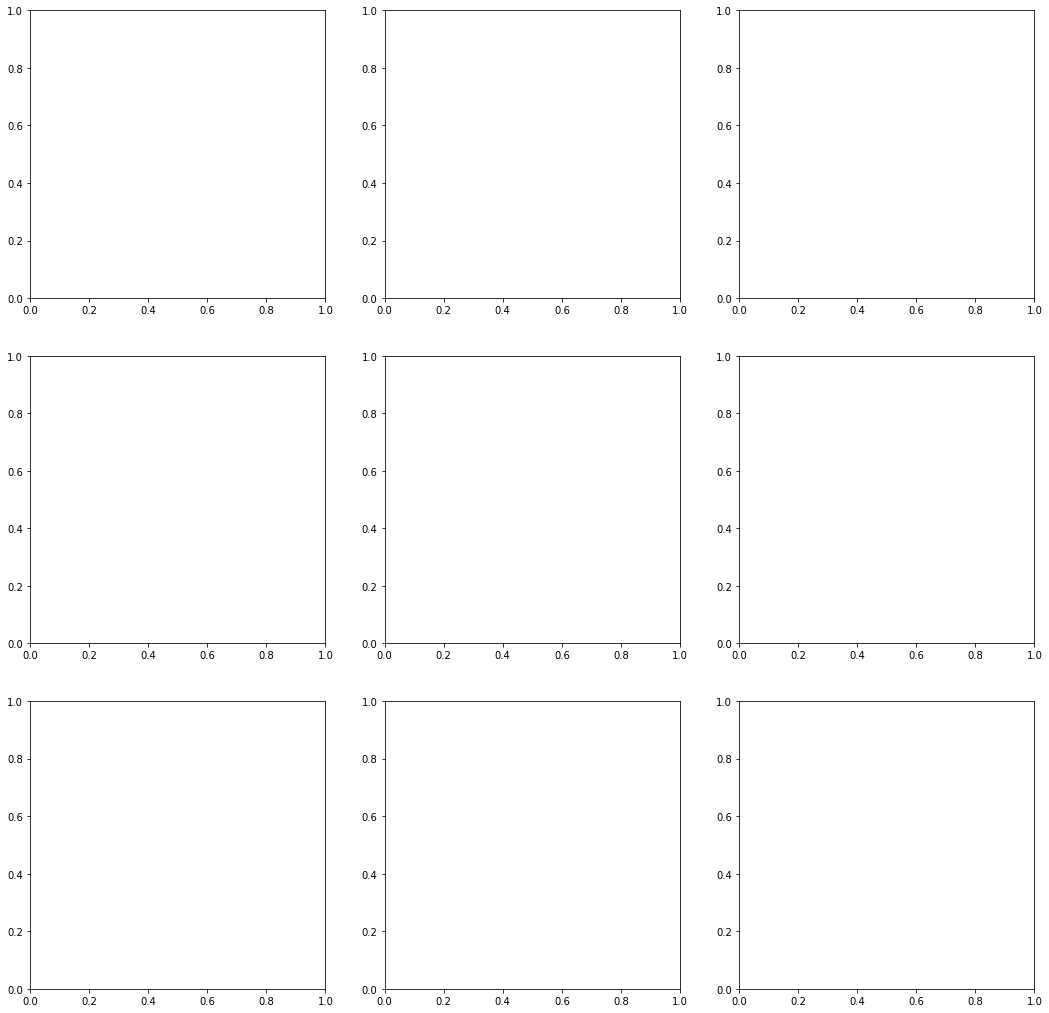

In [16]:
# Colouring based on signature

metrics= ['cosine', 'euclidean']
perplexities = [10, 30, 50]
learning_rates = [100, 200, 500]


for metric in metrics: 
    
    # Create a subplot grid for the scatterplots
    fig, axs = plt.subplots(len(perplexities), len(learning_rates), figsize=(18, 18))

    for i, perplexity in enumerate(perplexities):
        for j, learning_rate in enumerate(learning_rates):
            tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=1000, metric=metric)
            x_tsne = tsne.fit_transform(subject_doc_matrix)

            tsne_tw = trustworthiness(subject_doc_matrix, x_tsne, n_neighbors=10)
            # Create a scatterplot of the t-SNE embeddings
            sns.scatterplot(x=x_tsne[:, 0], y=x_tsne[:, 1], hue=df.signature.astype(str).str[0], ax=axs[i, j])
            axs[i, j].set_title(f'Perplexity: {perplexity}, Learning Rate: {learning_rate},\n Metric: {metric},  KL-divergence: {tsne.kl_divergence_:.3f}')

    # Add a common legend for all scatterplots
    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels)

    # Adjust the layout of the subplots
    # Adjust the spacing between subplots
    plt.subplots_adjust(bottom=0.2, left=0.2)
    fig.tight_layout()

    # Show the scatterplots
    plt.show()


c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


AttributeError: Can only use .str accessor with string values!

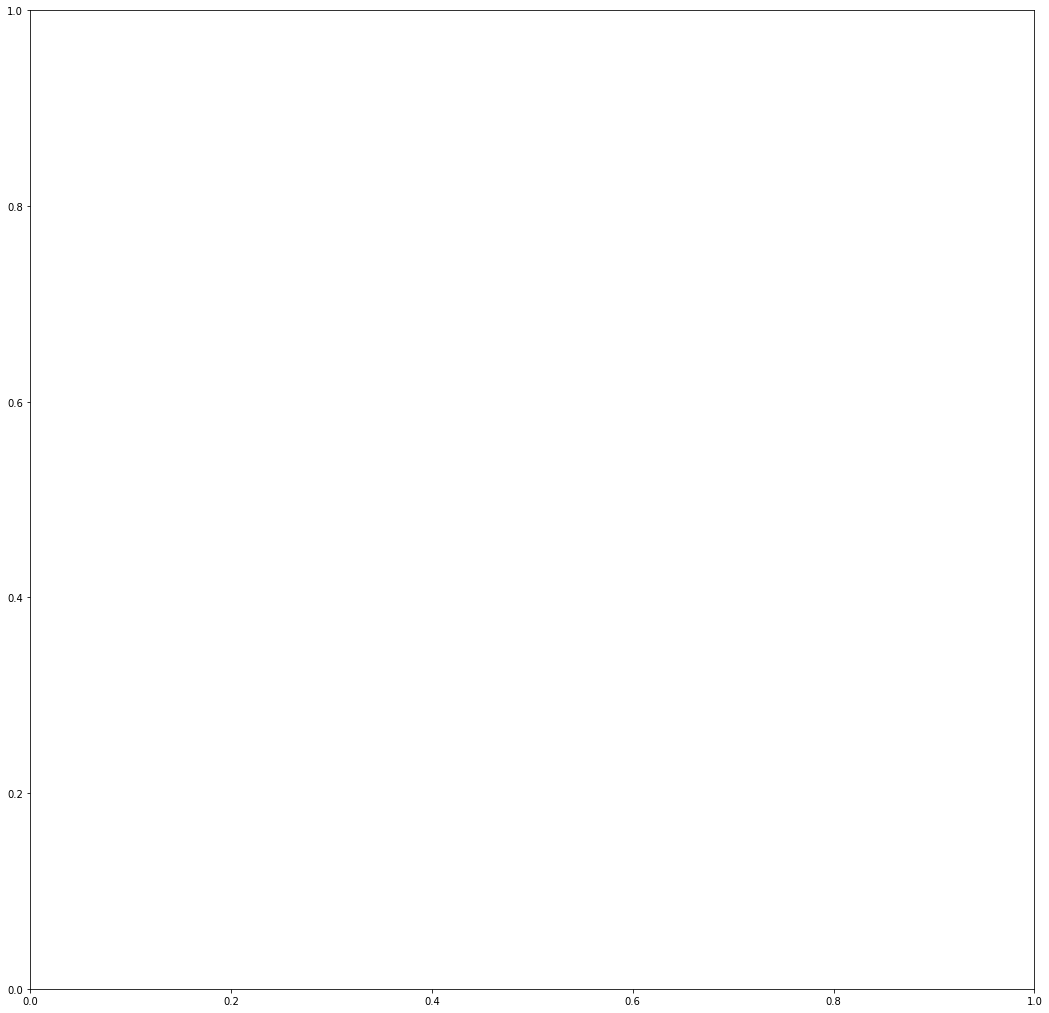

In [15]:
metric = 'cosine'
perplexity = 30
learning_rate = 200

fig, ax = plt.subplots(figsize=(18, 18))

tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=1000, metric=metric)
x_tsne = tsne.fit_transform(subject_doc_matrix)

tsne_tw = trustworthiness(subject_doc_matrix, x_tsne, n_neighbors=10)
# Create a scatterplot of the t-SNE embeddings
sns.scatterplot(x=x_tsne[:, 0], y=x_tsne[:, 1], hue=df.inventory_year.astype(str).str[0], ax=ax)
ax.set_title(f'Perplexity: {perplexity}, Learning Rate: {learning_rate},\n Metric: {metric},  KL-divergence: {tsne.kl_divergence_:.3f}')


# Show the scatterplots
plt.show()

### Evaluation

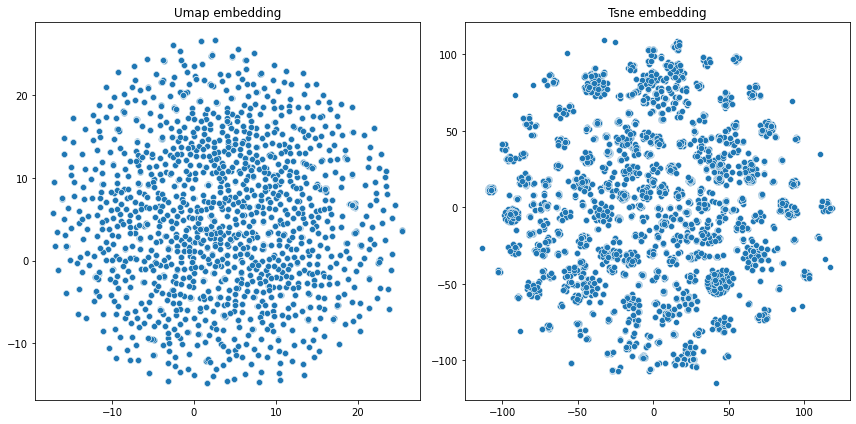

In [46]:
# Plotting

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot UMAP
sns.scatterplot(ax= axes[0], x=umap_emb[:,0], y=umap_emb[:,1], legend='full')
axes[0].set_title('Umap embedding')

# Plot tsne
sns.scatterplot(ax= axes[1], x=tsne_emb[:,0], y=tsne_emb[:,1], legend='full')
axes[1].set_title('Tsne embedding')

plt.tight_layout()
plt.show()

In [ ]:
# Calculate trustworthiness and continuity for UMAP
umap_tw = trustworthiness(subject_doc_matrix, umap_emb, n_neighbors=10)
#umap_cn = UMAP(n_neighbors=5, min_dist=0.3).fit(subject_doc_matrix).score(subject_doc_matrix)

# Calculate trustworthiness and continuity for t-SNE
tsne_tw = trustworthiness(subject_doc_matrix, tsne_emb, n_neighbors=10)
#tsne_cn = TSNE(n_components=2, perplexity=30, learning_rate=200).fit(subject_doc_matrix).kl_divergence_

print(f"UMAP Trustworthiness: {umap_tw:.3f}")
print(f"t-SNE Trustworthiness: {tsne_tw:.3f}")


## Export the embedding

In [47]:
emb = x_tsne

### Scale embedding

In [48]:
# Normalize 

embedding = emb * 100 # Multiply by 100
embedding = align_points_to_grid(embedding)

# Swap axes for horizontal position

ptp = np.ptp(embedding, axis=0)
if ptp[1]> ptp[0]:
    embedding[:, [1, 0]] = embedding[:, [0, 1]]

# Set value starting from 0

embedding[:, 0] = embedding[:, 0] - embedding[:, 0].min()
embedding[:, 1] = embedding[:, 1] - embedding[:, 1].min()

# # Set origin at the middle

ptp = np.ptp(embedding, axis=0)  
embedding[:, 0] = embedding[:, 0] - ptp[0] / 2
embedding[:, 1] = embedding[:, 1] - ptp[1] / 2

embedding = embedding.astype(int) # Set integer

embedding

array([[-6187, -7063],
       [-8152,    34],
       [ 3348,  7752],
       ...,
       [-8298, -2170],
       [-3421,  -310],
       [ 3493, -6305]])

# Cluster Identification

In [49]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=50, cluster_selection_method ='leaf')

clusterer.fit(embedding)
clusters = clusterer.labels_

# add cluster to dataframe

df['cluster'] = clusters

#Grouping by cluster

values = set(clusters)
if -1 in values: values.remove(-1)

clusters = [[index for index, cluster in enumerate(clusters) if cluster==value] for value in values]

# Wordclouds

In [53]:
for index, cluster in enumerate(clusters):

    # Preprocessing

    scale = 1
    
    min_X = min([i[0] for i in embedding[cluster]]) * scale
    max_X = max([i[0] for i in embedding[cluster]]) * scale
    min_Y = min([i[1] for i in embedding[cluster]]) * scale
    max_Y = max([i[1] for i in embedding[cluster]]) * scale

    width = max_X - min_X; height = max_Y - min_Y
    
    #points = list(map(lambda i: (i[0] * scale - min_X, i[1] * scale - min_Y), embedding[cluster]))
    points = [(i[0] * scale - min_X, i[1] * scale - min_Y) for i in embedding[cluster]]

    # Hull

    hull = ConvexHull(points)

    x_hull = np.append(hull.points[hull.vertices,0], hull.points[hull.vertices,0][0])
    y_hull = np.append(hull.points[hull.vertices,1], hull.points[hull.vertices,1][0])
    
    # Interpolation
    
    dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
    dist_along = np.concatenate(([0], dist.cumsum()))
    spline, u = interpolate.splprep([x_hull, y_hull], u=dist_along, s=0)
    interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
    interp_x, interp_y = interpolate.splev(interp_d, spline)    
    interp_points = list(zip(interp_x, interp_y))

    # Create mask

    print(width, height)
    img = Image.new(mode = "RGBA", size = (width, height), color = (255, 255, 255))
    draw = ImageDraw.Draw(img)
    # draw.polygon(points, fill=(0,0,0))
    draw.polygon(interp_points, fill=(0,0,0))
    mask = np.array(img)


    # Collect text

    text = []
    for id in cluster:
        text.append(df.iloc[id]['subject_list'])
    text = ' '.join(text)
    # text = text.replace('datum', 'data')
    # text = text.replace('medium', 'media')
    dictionary = multidict.MultiDict()
    _dictionary = {}


    # Frequency

    for _word in text.split(" "):
        val = _dictionary.get(_word, 0)
        _dictionary[_word.replace('_', ' ')] = val + 1
    for key in _dictionary:
        dictionary.add(key, _dictionary[key])


    # Wordcloud

    max_words = math.ceil(len(dictionary)*.5)
    def split_on_underscore(text):
        return text.replace('_', ' ')


    wc = WordCloud(
        mode = "RGBA",
        color_func=lambda *args, **kwargs: (0, 0, 0),
        font_path = 'Lato-Regular.ttf',
        mask=mask,
        
        normalize_plurals=False,
        prefer_horizontal= 1,
        
        margin=40,

        background_color=None,
        # background_color='black',

        max_words=max_words,
        
        min_font_size= 10,
        max_font_size= 100,
        # collocation_threshold = 20,
        relative_scaling = 0,
    )

    print(index, max_words, '-', end=' ')
    
    wc.generate_from_frequencies(dictionary) # generate word cloud
    file_path = path.join('data/' + f"{index:02}.png")
    
    wc.to_file('../BHVizApp/src/wordclouds/'+f"{index:02}.png") # store to file

1092 1171
0 8 - 583 1309
1 4 - 2620 1447
2 56 - 947 827
3 2 - 1238 1310
4 12 - 2547 2412
5 9 - 1310 1447
6 13 - 1092 1034
7 5 - 1674 1102
8 15 - 728 758
9 8 - 1237 1103
10 10 - 1455 964
11 10 - 946 1930
12 13 - 728 758
13 7 - 3494 3928
14 25 - 1893 3101
15 65 - 1310 1792
16 19 - 2257 2963
17 46 - 2038 2205
18 22 - 2038 1929
19 17 - 1092 826
20 15 - 1238 1308
21 8 - 1965 1585
22 12 - 1601 1378
23 11 - 2329 1310
24 27 - 1383 1791
25 16 - 3785 4135
26 32 - 1602 1171
27 7 - 1820 1723
28 20 - 1456 2068
29 12 - 2620 1516
30 41 - 2620 5375
31 60 - 1893 1516
32 21 - 2111 1929
33 16 - 1237 1447
34 9 - 2110 1516
35 18 - 946 1378
36 8 - 946 1103
37 30 - 2839 2136
38 21 - 3276 964
39 14 - 

# Export

In [33]:
# add coordinates to dataframe

df['embedding_x']  = embedding[:,0]
df['embedding_y']  = embedding[:,1]

df['id'] = df.bvb

df[columns_export].to_csv(path_out, index=False)